In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #         print(os.path.join(dirname, filename))
#         pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset,DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
from PIL import Image
import h5py
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel,pipeline

In [ ]:
# Initialize the BERT pipeline for feature extraction
embedder = pipeline('feature-extraction', model='bert-base-uncased', tokenizer='bert-base-uncased')

In [2]:
BATCH_SIZE=1 #16
LR=0.0002
BETAS=(0.5,0.999)
NUM_EPOCHS=10
z_dim=200

In [3]:
class CUBTextImageDataset(Dataset):
    def __init__(self, image_dir, text_dir, transform=None):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.transform = transform
        self.image_folders = sorted(os.listdir(image_dir))

    def __len__(self):
        return sum([len(os.listdir(os.path.join(self.image_dir, folder))) for folder in self.image_folders])

    def __getitem__(self, idx):
        folder_idx = 0
        while idx >= len(os.listdir(os.path.join(self.image_dir, self.image_folders[folder_idx]))):
            idx -= len(os.listdir(os.path.join(self.image_dir, self.image_folders[folder_idx])))
            folder_idx += 1
        
        image_folder = self.image_folders[folder_idx]
        image_file = sorted(os.listdir(os.path.join(self.image_dir, image_folder)))[idx]
        image_path = os.path.join(self.image_dir, image_folder, image_file)

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        base_name = os.path.splitext(image_file)[0]
        txt_path = os.path.join(self.text_dir, image_folder, base_name + ".txt")
        with open(txt_path, 'r') as file:
            txt_description = file.read().strip()
        return image, txt_description


In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
image_dir = '/kaggle/input/cub2002011/CUB_200_2011/images'
text_dir = '/kaggle/input/cub2002011/cvpr2016_cub/text_c10'

In [6]:
dataset = CUBTextImageDataset(image_dir=image_dir, text_dir=text_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
dataset

In [18]:
descriptions[0].split('\n')[0]

'yellow crown and breast and flank. gray wings and brown on top.'

In [11]:
# Check a few samples from the DataLoader
for images, descriptions in dataloader:
    for i in range(10):
        print("Batch of Images:", images.shape)
        print("Batch of Text Descriptions: ", descriptions[0].split('\n')[i])
    break

Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  a white bird with webbed feet, an orange beak and a red spot on its beak.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  a large bird with an expansive wing span, that has light grey feathers covering its entire body except for the tips of its wings which are black and white.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this bird has a wide wingspan, a long orange beak, and feathers that are white grey and black.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this bird has a bright orange bill, a light grey head, and orange feet.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this seagull has white feathers and a small orange beak.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this bird has white feathers covering its head neck and nape, grey on its belly, vent and inner 

In [34]:
def get_noise(BATCH_SIZE, z_dim, device='cpu'):
    return torch.randn(BATCH_SIZE, z_dim,1,1).to(device) 

In [58]:
!pip install torchfile

  Preparing metadata (setup.py) ... done
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5693 sha256=47ff0a6d051c24246f7125973004a975c8e7a77951725c73414dd8309f872e47
  Stored in directory: /root/.cache/pip/wheels/c7/e9/87/1c51daf8e468d5c14931f8ac3344880f903ba96b063675cac2
Successfully built torchfile


In [79]:
import os
import torchfile

# Path to the folder containing the .t7 files
t7_folder_path = '/kaggle/input/cub2002011/cvpr2016_cub/w2v_c10'

# List all .t7 files in the folder
t7_files = [f for f in os.listdir(t7_folder_path) if f.endswith('.t7')]

# Loop through each .t7 file and load it
for t7_file in t7_files:
    t7_file_path = os.path.join(t7_folder_path, t7_file)
    
    # Load the .t7 file
    t7_data = torchfile.load(t7_file_path)
    
    # Print the name of the file and the data
    print(f"File: {t7_file}")
    print("Data:", t7_data)


File: 151.Black_capped_Vireo.t7
Data: [[[ 6.90980302e-03 -1.28936375e-02  1.00518630e-02 ... -4.75358798e-02
   -8.18127898e-03 -4.57029066e-02]
  [-9.54793687e-02 -6.78271238e-02 -3.07955943e-02 ... -2.83956412e-02
   -5.17525481e-02 -6.63904652e-02]
  [ 2.47600035e-03  3.90216237e-02 -2.34775618e-02 ...  2.69138958e-02
    4.53812108e-02  1.90471664e-02]
  ...
  [ 1.97606041e-02 -2.53802590e-02  1.30630692e-02 ... -1.24906641e-02
   -8.47130420e-03 -1.15088993e-02]
  [ 3.92633844e-02  1.53955808e-02  5.44319566e-02 ...  6.96451150e-03
   -1.51662451e-02  1.32446271e-02]
  [ 6.98780904e-03 -1.20217444e-03 -7.30392354e-03 ...  3.92144966e-02
    2.37177095e-02  1.40379661e-02]]

 [[-2.71527764e-02 -3.96033714e-02 -2.64780381e-02 ... -1.16165734e-02
   -4.94941033e-02 -5.82937082e-02]
  [-4.56242107e-02 -4.95494335e-02 -8.51946421e-02 ... -6.36425914e-02
   -6.83065815e-02 -3.57187242e-02]
  [ 1.02494807e-02 -3.20049703e-02  6.87289501e-02 ... -3.64796515e-03
    3.18372785e-02  1.86447

In [81]:
print(t7_data.shape)
print(t7_data[1][0])

(60, 400, 10)
[ 0.02069136 -0.04573866 -0.04847965 -0.01829106 -0.00464554  0.00205419
 -0.02347178 -0.01791944 -0.03605664 -0.00627879]


In [42]:
class Text2ImageDataset(Dataset):

    def __init__(self, datasetFile, transform=None, split=0):
        self.datasetFile = datasetFile
        self.transform = transform
        self.dataset = None
        self.dataset_keys = None
        self.split = 'train' if split == 0 else 'valid' if split == 1 else 'test'
        self.h5py2int = lambda x: int(np.array(x))

    def __len__(self):
        f = h5py.File(self.datasetFile, 'r')
        self.dataset_keys = [str(k) for k in f[self.split].keys()]
        length = len(f[self.split])
        f.close()

        return length

    def __getitem__(self, idx):
        if self.dataset is None:
            self.dataset = h5py.File(self.datasetFile, mode='r')
            self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]

        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]

        # pdb.set_trace()

        right_image = bytes(np.array(example['img']))
        right_embed = np.array(example['embeddings'], dtype=float)
        wrong_image = bytes(np.array(self.find_wrong_image(example['class'])))
        inter_embed = np.array(self.find_inter_embed())

        right_image = Image.open(io.BytesIO(right_image)).resize((64, 64))
        wrong_image = Image.open(io.BytesIO(wrong_image)).resize((64, 64))

        right_image = self.validate_image(right_image)
        wrong_image = self.validate_image(wrong_image)

        txt = np.array(example['txt']).astype(str)

        sample = {
                'right_images': torch.FloatTensor(right_image),
                'right_embed': torch.FloatTensor(right_embed),
                'wrong_images': torch.FloatTensor(wrong_image),
                'inter_embed': torch.FloatTensor(inter_embed),
                'txt': str(txt)
                 }

        sample['right_images'] = sample['right_images'].sub_(127.5).div_(127.5)
        sample['wrong_images'] =sample['wrong_images'].sub_(127.5).div_(127.5)

        return sample

    def find_wrong_image(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        _category = example['class']

        if _category != category:
            return example['img']

        return self.find_wrong_image(category)

    def find_inter_embed(self):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        return example['embeddings']


    def validate_image(self, img):
        img = np.array(img, dtype=float)
        if len(img.shape) < 3:
            rgb = np.empty((64, 64, 3), dtype=np.float32)
            rgb[:, :, 0] = img
            rgb[:, :, 1] = img
            rgb[:, :, 2] = img
            img = rgb

        return img.transpose(2, 0, 1)

In [48]:
dat=Text2ImageDataset('/kaggle/input/cub2002011')

In [40]:
def visualize_images(path):
    image_filenames = os.listdir(path)
    num_images = min(10, len(image_filenames))
    num_rows = num_images // 5 + (1 if num_images % 5 else 0)
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    axes = axes.flatten() if num_rows > 1 else [axes]
    
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        axes[i].imshow(image, cmap='gray')
#         axes[i].set_title(image_filename, fontsize=8)

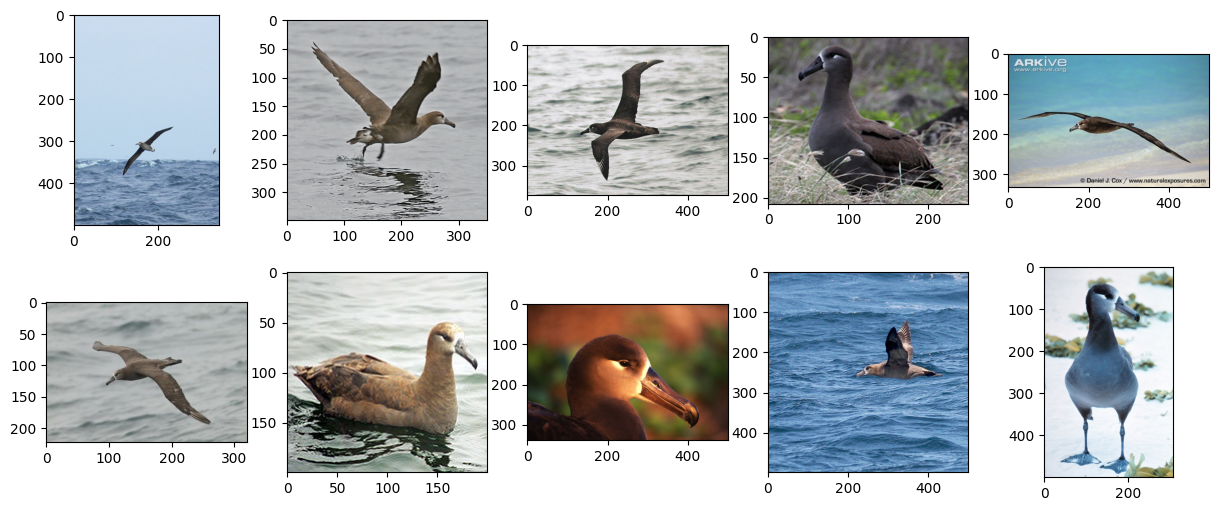

In [41]:
Black_footed_Albatross_dir='/kaggle/input/cub2002011/CUB_200_2011/images/001.Black_footed_Albatross'
visualize_images(Black_footed_Albatross_dir)

In [22]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,Gen=True,drop=False,norm=True,act='relu',kernel_size=3,stride=1,padding=1):
        super(ConvBlock,self).__init__()
        self.drop=drop
        self.norm=norm
        self.Gen=Gen
        self.dropout = nn.Dropout2d(0.5)
        self.act = act
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding) if Gen else nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
            nn.BatchNorm2d(out_channels) if norm else nn.Identity(),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        if self.drop:
            x = self.dropout(x)
        return self.block(x)

In [26]:
class Generator(nn.Module):
    def __init__(self,embed_dim=100,z_dim=100,num_channels=3,hidden_dim=32):
        super(Generator, self).__init__()
        self.linear=nn.Sequential(
            nn.Linear(embed_dim,128),
#             nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2)
        )
        self.conv1 = ConvBlock(z_dim+embed_dim,hidden_dim*16,Gen=True,drop=False,norm=False,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv2 = ConvBlock(hidden_dim*16,hidden_dim*8,Gen=True,drop=False,norm=False,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv3 = ConvBlock(hidden_dim*8,hidden_dim*4,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv4 = ConvBlock(hidden_dim*4,hidden_dim*2,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv5 = ConvBlock(hidden_dim*2,hidden_dim,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv6 = ConvBlock(hidden_dim,hidden_dim,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv7 = ConvBlock(hidden_dim,num_channels,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.tanh=nn.Tanh()
#         self.embedding=nn.Embedding(200,128)
    
    def forward(self,x,label):
        print(label.shape)# torch.Size([BATCH_SIZE,100])
        label=label.unsqueeze(2).unsqueeze(3)
        print(label.shape)# torch.Size([BATCH_SIZE,200,1,1])
        z=torch.cat([label,x],dim=1)
        print(z.shape)#     torch.Size([BATCH_SIZE, 200, 1, 1])
        x = self.conv1(z)
        print(x.shape) #    torch.Size([BATCH_SIZE, 512, 2, 2])
        x = self.conv2(x)
        print(x.shape) #    torch.Size([BATCH_SIZE, 256, 4, 4])
        x = self.conv3(x)
        print(x.shape) #    torch.Size([BATCH_SIZE, 128, 8, 8])
        x = self.conv4(x)
        print(x.shape) #    torch.Size([BATCH_SIZE, 64, 16, 16])
        x = self.conv5(x)
        print(x.shape) #    torch.Size([BATCH_SIZE, 32, 32, 32])
        x = self.conv6(x)
        print(x.shape) #    torch.Size([BATCH_SIZE, 32, 64, 64])
        x = self.conv7(x)
        print(x.shape) #    torch.Size([BATCH_SIZE, 3, 128, 128])
        return self.tanh(x)

In [27]:
gen=Generator()

In [29]:
embed=torch.rand(1,100)
img=torch.rand(1,100,1,1)
gen(img,embed).shape

torch.Size([1, 100])
torch.Size([1, 100, 1, 1])
torch.Size([1, 200, 1, 1])
torch.Size([1, 512, 2, 2])
torch.Size([1, 256, 4, 4])
torch.Size([1, 128, 8, 8])
torch.Size([1, 64, 16, 16])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 64, 64])
torch.Size([1, 3, 128, 128])


torch.Size([1, 3, 128, 128])

In [11]:
class Concat_embed(nn.Module):
    def __init__(self, embed_dim=1024, projected_embed_dim=128):
        super(Concat_embed, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(in_features=1024, out_features=128),
            nn.BatchNorm1d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

    def forward(self, inp, embed):
        projected_embed = self.projection(embed)
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([inp, replicated_embed], 1)

        return hidden_concat


In [47]:
class Discriminator(nn.Module):
#     embed_dim=1024,z_dim=100,num_channels=3,hidden_dim=32
    def __init__(self,embed_dim=1024,in_channels=3,hidden_dim=64):
        super(Discriminator,self).__init__()
        self.conv1 = ConvBlock(in_channels,hidden_dim,Gen=False,drop=False,norm=False,act='leaky',kernel_size=4,stride=2,padding=1)
        self.conv2 = ConvBlock(hidden_dim,hidden_dim*2,Gen=False,drop=False,norm=False,act='leaky',kernel_size=4,stride=2,padding=1)
        self.conv3 = ConvBlock(hidden_dim*2,hidden_dim*4,Gen=False,drop=True,norm=True,act='leaky',kernel_size=4,stride=2,padding=1)
        self.conv4 = ConvBlock(hidden_dim*4,hidden_dim*8,Gen=False,drop=True,norm=True,act='leaky',kernel_size=4,stride=2,padding=1)
        self.conv5 = ConvBlock(hidden_dim*8,hidden_dim*16,Gen=False,drop=True,norm=True,act='leaky',kernel_size=4,stride=2,padding=1)
#         self.conv6 = ConvBlock(hidden_dim*16,1,Gen=False,drop=True,norm=True,act='leaky',kernel_size=4,stride=2,padding=1)
#         self.conv7 = ConvBlock(hidden_dim,3,Gen=False,drop=True,norm=True,act='leaky',kernel_size=4,stride=2,padding=1)
        self.projector=nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=128),
#             nn.BatchNorm1d(num_features=128),
            nn.LeakyReLU(0.2)
        )
        self.conv7=nn.Sequential(
            nn.Conv2d(hidden_dim*16*2,1,4,2,1),
            nn.Sigmoid()
        )
    
    
    def forward(self,x,embed):
        x=self.conv1(x)
        print(x.shape)
        x=self.conv2(x)
        print(x.shape)
        x=self.conv3(x)
        print(x.shape)
        x=self.conv4(x)
        print(x.shape)
        x_intermediate=self.conv5(x)
        print(x_intermediate.shape)
#         projected_embed=self.projector(embed)
#         print(projected_embed.shape)
        replicated_embed = embed.repeat(1,4, 1, 1).permute(0,3,1,2)
#         print
        print(replicated_embed.shape)
        x = torch.cat([x_intermediate, replicated_embed], dim=1)
        x=self.conv7(x)
        x=x.view(-1,1).squeeze(1)
        return x,x_intermediate

In [48]:
disc=Discriminator()

In [43]:
embed=torch.rand(1,4,1024)
embed=embed.repeat(1,4,1,1).permute(0,3,1,2)
embed.shape

torch.Size([1, 1024, 4, 4])

In [49]:
embed=torch.rand(1,4,1024)
img=torch.rand(1,3,128,128)
disc(img,embed)

torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 256, 16, 16])
torch.Size([1, 512, 8, 8])
torch.Size([1, 1024, 4, 4])
torch.Size([1, 1024, 4, 4])


(tensor([0.5921, 0.5667, 0.4753, 0.5041], grad_fn=<SqueezeBackward1>),
 tensor([[[[-0.1138,  1.3626,  0.6548,  0.7655],
           [-0.1921,  1.3476, -0.3013, -0.2581],
           [-0.0479,  0.8804, -0.1945,  0.3457],
           [-0.2259,  1.1779,  0.9502, -0.1634]],
 
          [[ 0.3838,  1.3738,  1.1211,  1.0090],
           [ 0.0334, -0.0457, -0.2635, -0.0128],
           [-0.4163,  0.3546, -0.0114, -0.0900],
           [-0.0118,  0.9673, -0.3746,  0.8865]],
 
          [[-0.1773,  0.2135, -0.1975, -0.2078],
           [ 0.7994,  0.4795, -0.1845,  0.1821],
           [ 2.3173,  1.3603,  0.5469, -0.2570],
           [-0.2075,  0.9042, -0.0228, -0.1062]],
 
          ...,
 
          [[ 0.8454,  0.4493,  1.6725, -0.2943],
           [ 0.6208,  0.4380,  0.5467, -0.0309],
           [ 1.6053, -0.3436, -0.1967, -0.1701],
           [ 0.0669,  0.6769, -0.1552, -0.1935]],
 
          [[ 1.6690,  1.1535, -0.2424,  0.0446],
           [-0.1643, -0.0738, -0.1003, -0.0811],
           [ 1.567

In [8]:
# # Define a function to get BERT embeddings
def get_bert_embedding(caption):
    embedding = embedder(caption)
    mean_embedding = np.mean(embedding[0], axis=0)
    return mean_embedding

In [29]:
# Check a few samples from the DataLoader
for images, descriptions in dataloader:
    for i in range(10):
        print("Batch of Images:", images.shape)
        print("Batch of Text Descriptions: ", descriptions[0].split('\n')[i])
    break

Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this bird has a very noticeable black crown, nape and cheek patch while its eyebrow is starkwhite, it has a short, black beak and mottled yellow wings.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this bird is brown with a white chest and has a very short beak.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this small bird has a black head with a white eyepatch and white throat.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this is a small, white bird with a black crown and brown wingbars.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  this small white bird has a black head and yellow and black wings.
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions:  the small bird has a black crown with a white belly
Batch of Images: torch.Size([1, 3, 128, 128])
Batch of Text Descriptions: 

In [14]:
text=descriptions[0].split('\n')[0]

In [17]:
test_df=pd.DataFrame(descriptions[0].split('\n'))

In [20]:
# # Assign the embeddings to a new column in the sampled dataframe
test_df['vector'] = test_df[0].apply(lambda x: get_bert_embedding(x))
test_df.head()

,0,vector
0,"a white bird with webbed feet, an orange beak ...","[-0.014718351065225545, -0.05030688155619871, ..."
1,"a large bird with an expansive wing span, that...","[-0.1399901636847944, 0.04223645486953584, -0...."
2,"this bird has a wide wingspan, a long orange b...","[-0.04294362664222717, 0.2631648364274398, -0...."
3,"this bird has a bright orange bill, a light gr...","[-0.0761377125684368, 0.17957989935223995, -0...."
4,this seagull has white feathers and a small or...,"[-0.25227072884639107, 0.11543269527610392, -0..."


In [37]:
test_df['vector'].iloc[0].shape

(768,)

In [35]:
test_df[0].iloc[1].split(' ').__len__()

29